Processando: /content/sample_data/Foto2.png


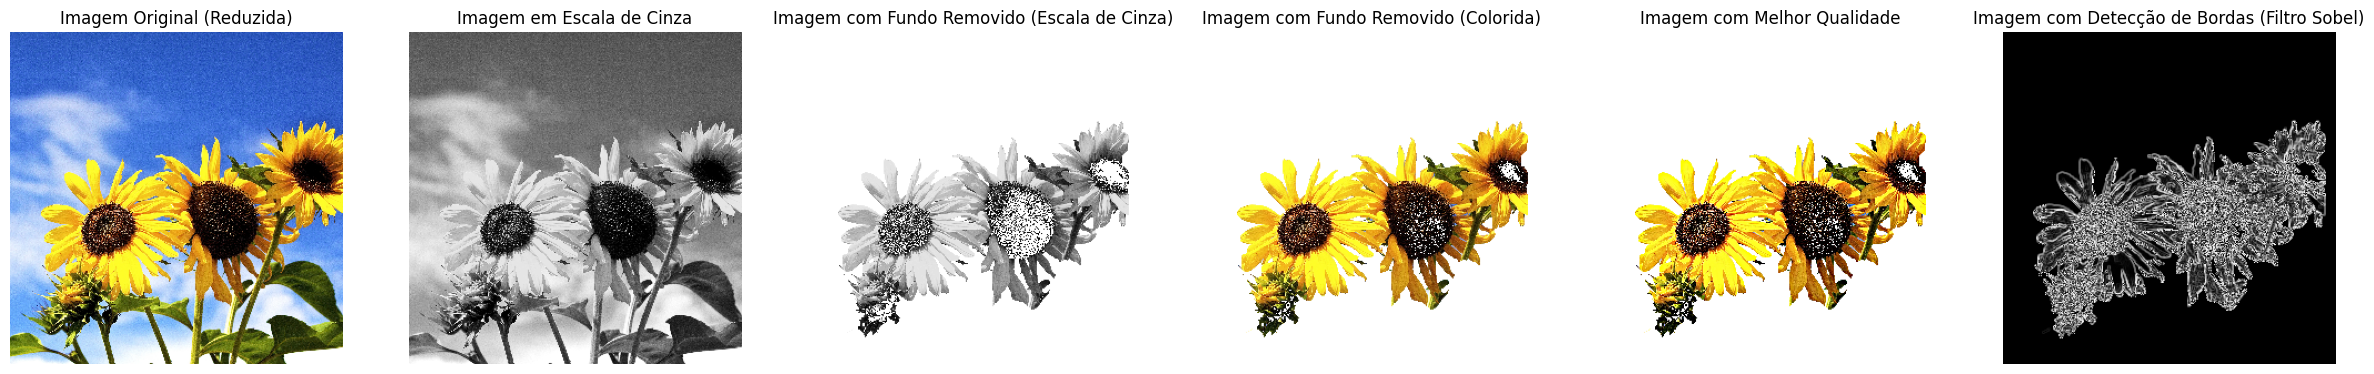

Processando: /content/sample_data/Foto4.png


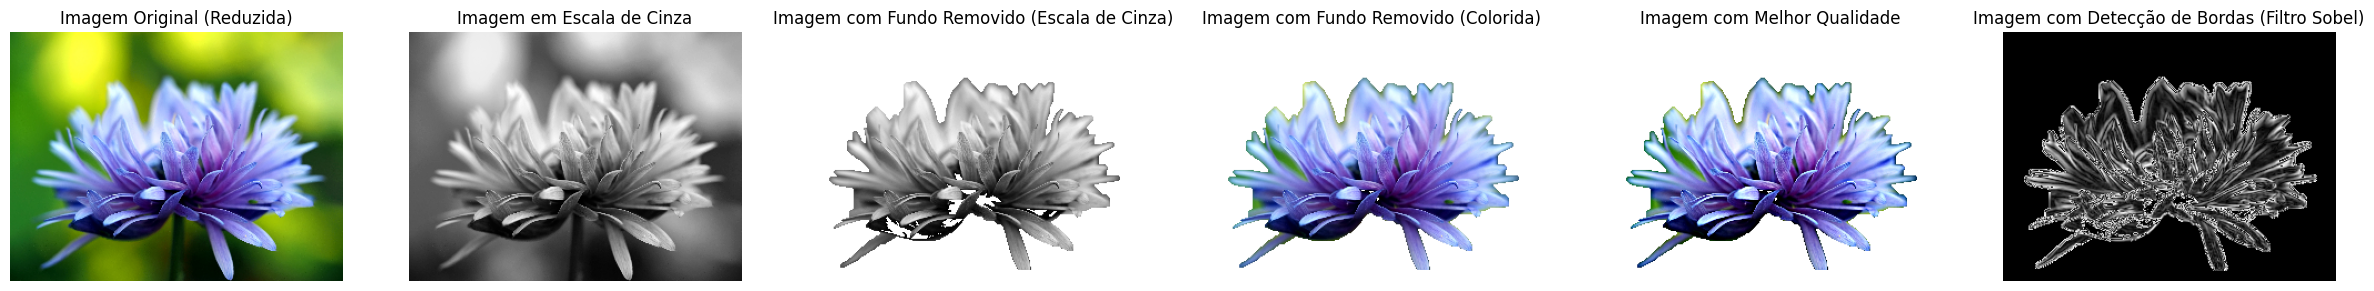

Processando: /content/sample_data/Foto3.png


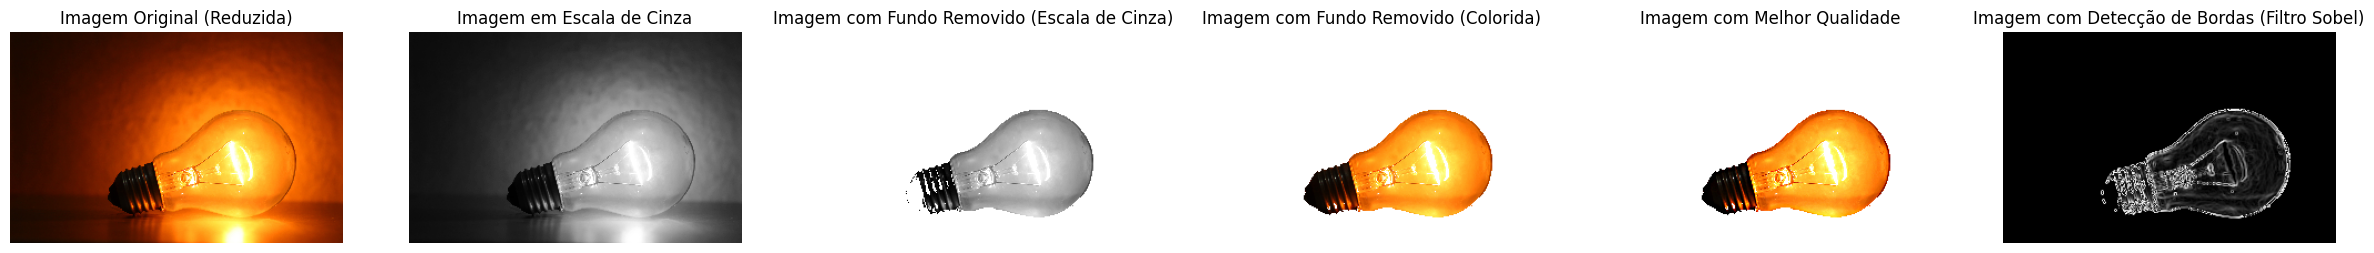

Processando: /content/sample_data/Foto1.png


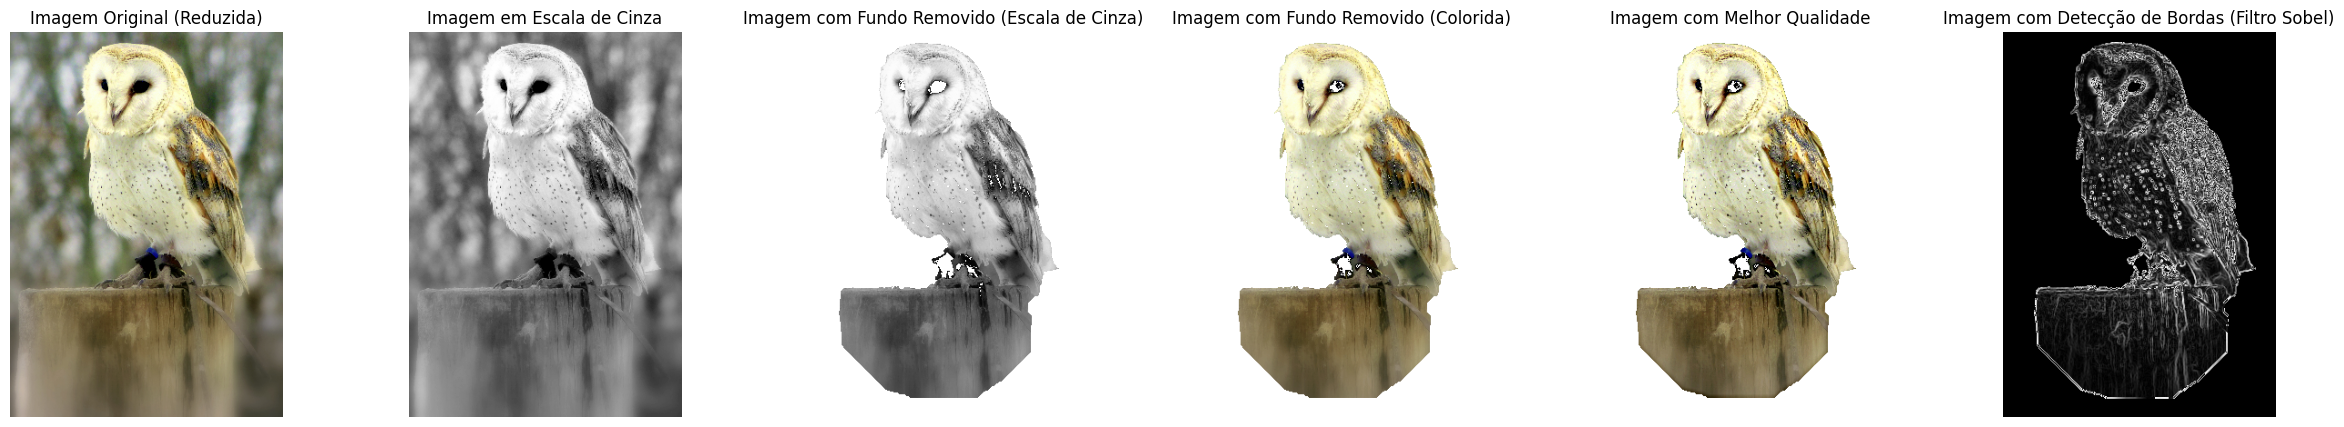

Processamento e exibição concluídos.


In [9]:
import cv2  # Biblioteca para manipulação de imagens
import numpy as np  # Biblioteca para operações com matrizes e arrays
import glob  # Biblioteca para encontrar arquivos em diretórios
import os  # Biblioteca para manipulação de diretórios e arquivos
import matplotlib.pyplot as plt  # Biblioteca para visualização de gráficos e imagens

# Função para redimensionar a imagem e acelerar o processamento
def resize_image(image, width=300):
    # Calcula a proporção da altura com base na largura desejada
    aspect_ratio = image.shape[0] / image.shape[1]
    # Calcula a nova altura para manter a proporção
    new_height = int(width * aspect_ratio)
    # Redimensiona a imagem para a largura e altura calculadas
    return cv2.resize(image, (width, new_height))

# Função para remover o fundo de uma imagem usando o algoritmo GrabCut
def remove_background(image):
    # Redimensiona a imagem para acelerar o processamento
    resized_image = resize_image(image)

    # Inicializa uma máscara de zeros (mesmo tamanho que a imagem)
    mask = np.zeros(resized_image.shape[:2], np.uint8)
    # Inicializa modelos de fundo e de primeiro plano para o GrabCut
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)

    # Define um retângulo ao redor do objeto principal para orientar o GrabCut
    rect = (10, 10, resized_image.shape[1] - 20, resized_image.shape[0] - 20)
    # Executa o GrabCut usando a máscara e os modelos de fundo/objeto
    cv2.grabCut(resized_image, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)

    # Cria uma máscara final onde 1 representa o objeto e 0 o fundo
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype("uint8")

    # Converte a imagem para escala de cinza
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    # Remove o fundo da imagem colorida usando a máscara criada
    result_with_background_removed = resized_image * mask2[:, :, np.newaxis]
    # Remove o fundo da imagem em escala de cinza usando a máscara
    gray_result_with_background_removed = gray_image * mask2

    # Substitui os pixels quase pretos (fundo) por branco na imagem em escala de cinza
    gray_result_with_background_removed[gray_result_with_background_removed < 10] = 255

    # Substitui pixels pretos (fundo) por branco na imagem colorida
    result_with_background_removed[np.all(result_with_background_removed == 0, axis=-1)] = [255, 255, 255]

    # Retorna as diferentes versões da imagem
    return resized_image, gray_image, mask2, result_with_background_removed, gray_result_with_background_removed

# Função para aplicar o filtro de nitidez na imagem
def enhance_image_quality(image):
    # Aplica um desfoque gaussiano para suavizar a imagem
    gaussian_blur = cv2.GaussianBlur(image, (9, 9), 10.0)
    # Combina a imagem original e a desfocada para realçar os detalhes
    sharpened_image = cv2.addWeighted(image, 1.5, gaussian_blur, -0.5, 0)
    return sharpened_image

# Função para aplicar o filtro de detecção de bordas (Sobel) na imagem em tons de cinza
def apply_sobel_filter(gray_image):
    # Calcula as bordas horizontais
    sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
    # Calcula as bordas verticais
    sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
    # Calcula a magnitude combinada das bordas horizontais e verticais
    sobel_combined = cv2.magnitude(sobel_x, sobel_y)
    # Converte a imagem para tipo uint8 para exibição
    sobel_combined = np.uint8(sobel_combined)
    return sobel_combined

# Função para processar e exibir uma única imagem
def process_single_image(image_path):
    # Carrega a imagem do caminho especificado
    image = cv2.imread(image_path)
    # Verifica se a imagem foi carregada corretamente
    if image is None:
        print(f"Erro ao carregar a imagem: {image_path}")
        return

    try:
        # Remove o fundo e obtém as versões da imagem
        original, gray, mask, result_with_background_removed, gray_result_with_background_removed = remove_background(image)

        # Aplica o filtro de nitidez na imagem
        enhanced_image = enhance_image_quality(result_with_background_removed)

        # Aplica o filtro Sobel para detecção de bordas na imagem em escala de cinza
        sobel_image = apply_sobel_filter(gray_result_with_background_removed)

        # Configura a exibição das imagens em uma grade com 6 colunas
        fig, axes = plt.subplots(1, 6, figsize=(30, 5))

        # Exibe a imagem original redimensionada
        axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        axes[0].set_title("Imagem Original (Reduzida)")
        axes[0].axis('off')

        # Exibe a imagem em escala de cinza
        axes[1].imshow(gray, cmap='gray')
        axes[1].set_title("Imagem em Escala de Cinza")
        axes[1].axis('off')

        # Exibe a imagem com fundo removido (em escala de cinza)
        axes[2].imshow(gray_result_with_background_removed, cmap='gray')
        axes[2].set_title("Imagem com Fundo Removido (Escala de Cinza)")
        axes[2].axis('off')

        # Exibe a imagem com fundo removido (colorida)
        axes[3].imshow(cv2.cvtColor(result_with_background_removed, cv2.COLOR_BGR2RGB))
        axes[3].set_title("Imagem com Fundo Removido (Colorida)")
        axes[3].axis('off')

        # Exibe a imagem com qualidade melhorada
        axes[4].imshow(cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB))
        axes[4].set_title("Imagem com Melhor Qualidade")
        axes[4].axis('off')

        # Exibe a imagem com bordas detectadas pelo filtro Sobel
        axes[5].imshow(sobel_image, cmap='gray')
        axes[5].set_title("Imagem com Detecção de Bordas (Filtro Sobel)")
        axes[5].axis('off')

        # Mostra todas as imagens na tela
        plt.show()
    except Exception as e:
        # Exibe uma mensagem de erro caso haja falha no processamento
        print(f"Erro ao processar a imagem {image_path}: {e}")

# Função para processar todas as imagens e exibir uma por uma
def process_images(input_path):
    # Verifica se o caminho é um arquivo ou um diretório e obtém as imagens
    images_to_process = [input_path] if os.path.isfile(input_path) else glob.glob(os.path.join(input_path, "*.png"))
    # Caso não encontre imagens, exibe uma mensagem de erro
    if not images_to_process:
        print("Caminho inválido ou nenhuma imagem encontrada.")
        return

    # Processa cada imagem encontrada
    for image_path in images_to_process:
        print(f"Processando: {image_path}")
        process_single_image(image_path)

    # Exibe uma mensagem de conclusão
    print("Processamento e exibição concluídos.")

# Exemplo de uso: processa uma imagem específica (ajuste o caminho conforme necessário)
process_images("/content/sample_data")